In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
from os import listdir
from os.path import exists

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [57]:
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn import manifold, decomposition

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import *

In [3]:
import cv2

In [4]:
import tensorflow as tf

from tensorflow.keras.models import Model
# Utilisation d'autre chose que VGG16 car trop lent et surdimensionné pour nous
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [5]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
from plot_keras_history import show_history, plot_history

# Récupération des données

In [7]:
path_csv = './data/Flipkart/flipkart_com-ecommerce_sample_1050.csv'
path_img = './data/Flipkart/Images'
path_img_little = './data/Flipkart/ImagesLittles'

In [8]:
data = pd.read_csv(path_csv)

## Mise en forme et quelques stats

### Gestion de l'arbre de catégories

In [9]:
# Récupère le noeud à la profondeur "level"
# (ou la feuille si level va trop profond)
# (ou la racine si level remonte trop)
def get_from_tree(tree, level):
    if len(tree) > level and len(tree) >= -level:
        return tree[level]
    elif len(tree) < -level:
        return tree[0]
    else:
        return tree[-1]

In [10]:
data['product_category_list'] = data['product_category_tree'].apply(lambda e : e[2:-2]).str.split(' >> ')

In [11]:
print("Nombre total de catégories possible (en comptant noeuds et feuilles) :")
print(len(data['product_category_list'].explode().unique()))

Nombre total de catégories possible (en comptant noeuds et feuilles) :
1126


In [12]:
print("Nombre total de catégories (feuilles) :")
print(len(data['product_category_tree'].unique()))

Nombre total de catégories (feuilles) :
642


In [13]:
tmp = data['product_category_list'].str.len()
print("Taille minimum d'une branche :", tmp.min())
print("Taille maximum d'une branche :", tmp.max())

Taille minimum d'une branche : 2
Taille maximum d'une branche : 7


Observation des catégories récupérées selon le niveau choisi :

In [14]:
level = 1

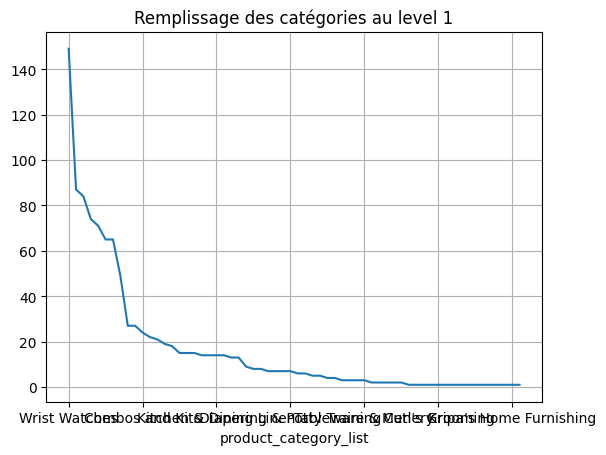

In [15]:
tmp = data['product_category_list'].apply(lambda tree : get_from_tree(tree, level))
ax = tmp.value_counts().plot(grid=True, title="Remplissage des catégories au level "+str(level))

In [16]:
level = -1

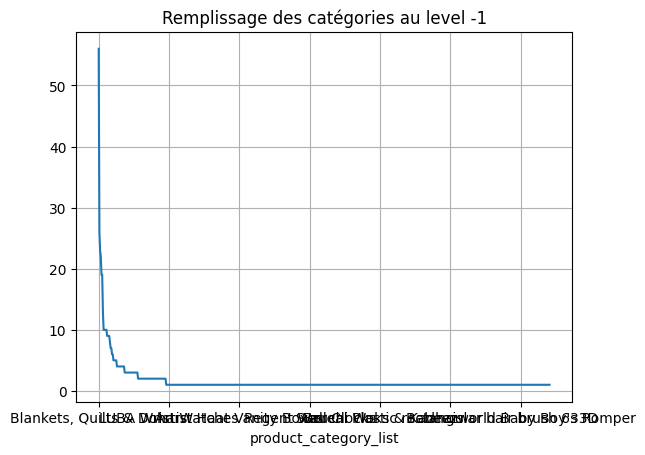

In [17]:
tmp = data['product_category_list'].apply(lambda tree : get_from_tree(tree, level))
ax = tmp.value_counts().plot(grid=True, title="Remplissage des catégories au level "+str(level))

Visualisation de l'arbre

In [18]:
import graphviz

In [19]:
dot = graphviz.Digraph()

lien_deja = set()

# Ajouter la racine de l'arbre
dot.node('Racine')

for n in data['product_category_list'].explode().unique():
    dot.node(n)

def ajouter_lien(precedent, actuel, suite):
    nom = "{}/{}".format(precedent, actuel)
    if nom not in lien_deja:
        dot.edge(precedent, actuel)
        lien_deja.add(nom)
    
    if len(suite) > 0 :
        ajouter_lien(actuel, suite[0], suite[1:])

for l in data['product_category_list']:
    ajouter_lien('Racine', l[0], l[1:])

# Affichage l'arbre
# dot.render('categories', view=True)

#### Choix du niveau de catégorie classique

In [20]:
level = 0

In [21]:
data['cat_group'] = data['product_category_list'].apply(lambda tree : get_from_tree(tree, level))

#### Version personalisée des catégories

In [22]:
# Nombre minimum d'éléments pour faire une catégorie
nb_min_elements = 30

In [23]:
index = -1

In [24]:
# Initialisation des données
tmp = data[['product_category_list']].copy()
tmp.columns = ['list']
tmp['actual'] = tmp['list'].apply(lambda tree : get_from_tree(tree, index))
tmp

,list,actual
0,"[Home Furnishing, Curtains & Accessories, Curt...",Elegance Polyester Multicolor Abstract Eyelet ...
1,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...","Sathiyas Cotton Bath Towel (3 Bath Towel, Red,..."
2,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",Eurospa Cotton Terry Face Towel Set (20 PIECE ...
3,"[Home Furnishing, Bed Linen, Bedsheets, SANTOS...",SANTOSH ROYAL FASHION Cotton Printed King size...
4,"[Home Furnishing, Bed Linen, Bedsheets, Jaipur...",Jaipur Print Cotton Floral King sized Double B...
...,...,...
1045,"[Baby Care, Baby & Kids Gifts, Stickers, Oren ...",Oren Empower Stickers
1046,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Wallmantra Stickers
1047,"[Baby Care, Baby & Kids Gifts, Stickers, Uberl...",Uberlyfe Stickers
1048,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Wallmantra Stickers


Application de l'algo : On part des feuilles de l'arbre, et tant qu'il n'y a pas assez l'éléments dans la catégorie on les remonte d'un niveau

In [25]:
old_unique = 0

In [26]:
while old_unique != len(tmp['actual'].unique()):
    old_unique = len(tmp['actual'].unique())
    index -= 1
    tmp_actual = tmp.groupby('actual').count()
    tmp_actual = tmp_actual.loc[tmp_actual['list']<nb_min_elements]
    
    mask = tmp['actual'].isin(tmp_actual.index)
    
    tmp.loc[mask, 'actual'] = tmp.loc[mask, 'list'].apply(lambda tree : get_from_tree(tree, index))

In [27]:
# Modification pour éviter une catégorie qui se retrouve seule sinon
tmp.loc[tmp['actual']=="Wrist Watches", 'actual'] = "Watches"

In [28]:
tmp['actual'].value_counts()

actual
Watches                       150
Baby Care                     110
Home Furnishing                93
Beauty and Personal Care       86
Kitchen & Dining               76
Coffee Mugs                    74
Combos                         64
Computers                      63
Showpieces                     60
Blankets, Quilts & Dohars      57
Home Decor & Festive Needs     56
Routers                        49
Baby Girls' Clothes            40
USB Gadgets                    38
Ethnic                         34
Name: count, dtype: int64

In [29]:
data['cat_group'] = tmp['actual']

### Finalisation mise en forme

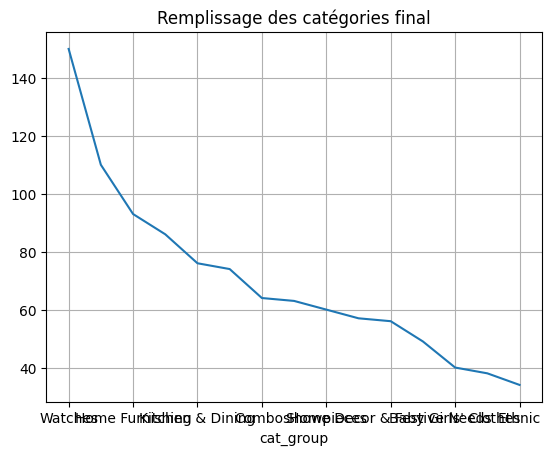

In [30]:
ax = data['cat_group'].value_counts().plot(grid=True, title="Remplissage des catégories final")

In [31]:
# Nombre minimum d'éléments pour garder cette catégorie
nb_min_elements = 3

Mise en forme

In [32]:
data_final = data[['image', 'product_category_list', 'cat_group']].copy()
data_final.columns = ['img', 'cat_lst', 'cat']
data_final['img'] = path_img+'/'+data_final['img']

Conversion des labels

In [33]:
list_labels = list(data_final['cat'].value_counts().index)
data_final['label'] = data_final['cat'].apply(lambda e : list_labels.index(e))

Récupération d'infos et suppression des lignes avec des catégories trop vides

In [34]:
nb_cat_little = (data_final['cat'].value_counts() > nb_min_elements).sum()
nb_cat = len(list_labels)

In [35]:
print("Nombre de catégories total :", nb_cat)
print("Nombre de catégories de plus de", nb_min_elements, "élément :", nb_cat_little)

Nombre de catégories total : 15
Nombre de catégories de plus de 3 élément : 15


In [36]:
data_little = data_final.loc[data_final['cat'].isin(list_labels[:nb_cat_little])].copy().reset_index(drop=True)

In [37]:
data_little

,img,cat_lst,cat,label
0,./data/Flipkart/Images/55b85ea15a1536d46b7190a...,"[Home Furnishing, Curtains & Accessories, Curt...",Home Furnishing,2
1,./data/Flipkart/Images/7b72c92c2f6c40268628ec5...,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",Baby Care,1
2,./data/Flipkart/Images/64d5d4a258243731dc7bbb1...,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",Baby Care,1
3,./data/Flipkart/Images/d4684dcdc759dd9cdf41504...,"[Home Furnishing, Bed Linen, Bedsheets, SANTOS...",Home Furnishing,2
4,./data/Flipkart/Images/6325b6870c54cd47be6ebfb...,"[Home Furnishing, Bed Linen, Bedsheets, Jaipur...",Home Furnishing,2
...,...,...,...,...
1045,./data/Flipkart/Images/958f54f4c46b53c8a0a9b81...,"[Baby Care, Baby & Kids Gifts, Stickers, Oren ...",Baby Care,1
1046,./data/Flipkart/Images/fd6cbcc22efb6b761bd564c...,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Baby Care,1
1047,./data/Flipkart/Images/5912e037d12774bb73a2048...,"[Baby Care, Baby & Kids Gifts, Stickers, Uberl...",Baby Care,1
1048,./data/Flipkart/Images/c3edc504d1b4f0ba6224fa5...,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Baby Care,1


In [38]:
data_little.to_csv("./data/data_little.csv")

# Mon CODE

In [39]:
def show_representation(data, cat, limit=None, X_tsne=None, title=''):
    if X_tsne is None:
        tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random')
        X_tsne = tsne.fit_transform(data)
    
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
    df_tsne["class"] = cat.reset_index(drop=True)
    
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne1", y="tsne2",
        hue="class",
        palette=sns.color_palette('tab10', n_colors=nb_cat_little), s=50,
        data=df_tsne,
        legend="brief")

    plt.title(title, fontsize = 14, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
    plt.legend(prop={'size': 8}) 

    plt.show()
    
    return X_tsne

In [40]:
input_shape = MobileNetV2().input_shape
input_shape

(None, 224, 224, 3)

In [41]:
base_model = MobileNetV2(include_top=False, input_shape=input_shape[1:])
base_model.trainable = False

In [42]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

## Conversion

In [43]:
def preprocess_image(path):
    image = load_img(path, target_size=input_shape[1:3], interpolation='lanczos')
    image = img_to_array(image)
    image = preprocess_input(image)
    return image

In [44]:
def cat_to_label(l):
    return np.argmax(l)

In [45]:
data_X = list(data_little["img"].apply(preprocess_image))
data_X = np.asarray(data_X).astype(np.float32)

In [46]:
data_y = to_categorical(data_little['label'], num_classes=nb_cat_little)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.33, stratify=data_y)

In [48]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(nb_cat_little*10, activation='relu')
drop_out = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(nb_cat_little*4, activation='relu')
prediction_layer = layers.Dense(nb_cat_little, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    drop_out,
    dense_layer_2,
    prediction_layer
])

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 150)               9408150   
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 60)                9060      
                                                                 
 dense_2 (Dense)             (None, 15)                915       
                                                        

In [50]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy',  min_delta = 0.02, mode='max', patience=5, restore_best_weights=True)
es = EarlyStopping(monitor='val_loss', min_delta = 0.02, mode='min', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/20
18/18 [==============================] - 24s 1s/step - loss: 4.4811 - accuracy: 0.3577 - val_loss: 2.0489 - val_accuracy: 0.5319
Epoch 2/20
18/18 [==============================] - 22s 1s/step - loss: 1.6013 - accuracy: 0.6744 - val_loss: 1.9485 - val_accuracy: 0.6170
Epoch 3/20
18/18 [==============================] - 20s 1s/step - loss: 0.8744 - accuracy: 0.8114 - val_loss: 1.7376 - val_accuracy: 0.6383
Epoch 4/20
18/18 [==============================] - 22s 1s/step - loss: 0.5105 - accuracy: 0.8648 - val_loss: 1.6722 - val_accuracy: 0.6809
Epoch 5/20
18/18 [==============================] - 19s 1s/step - loss: 0.2454 - accuracy: 0.9217 - val_loss: 1.5507 - val_accuracy: 0.6809
Epoch 6/20
18/18 [==============================] - 21s 1s/step - loss: 0.1668 - accuracy: 0.9520 - val_loss: 1.7691 - val_accuracy: 0.6525
Epoch 7/20
18/18 [==============================] - 19s 1s/step - loss: 0.1988 - accuracy: 0.9555 - val_loss: 1.7372 - val_accuracy: 0.6525
Epoch 8/20
18/18 [==

In [51]:
pred_train = model.predict(X_train)

22/22 [==============================] - 19s 840ms/step


In [54]:
balanced_accuracy_score([cat_to_label(e) for e in pred_train], [cat_to_label(e) for e in y_train])

0.9301570983180076

In [55]:
labels_little = data_little.sort_values('label')['cat'].drop_duplicates().to_list()

In [58]:
print(classification_report(
    [cat_to_label(e) for e in y_train],
    [cat_to_label(e) for e in pred_train],
    target_names=labels_little,
    zero_division=0))

                            precision    recall  f1-score   support

                   Watches       0.99      1.00      1.00       100
                 Baby Care       0.92      0.91      0.91        74
           Home Furnishing       0.88      0.95      0.91        62
  Beauty and Personal Care       0.98      0.93      0.96        58
          Kitchen & Dining       0.92      0.90      0.91        51
               Coffee Mugs       0.94      1.00      0.97        50
                    Combos       1.00      0.98      0.99        43
                 Computers       0.91      0.98      0.94        42
                Showpieces       0.85      0.88      0.86        40
 Blankets, Quilts & Dohars       0.86      0.95      0.90        38
Home Decor & Festive Needs       1.00      0.70      0.83        37
                   Routers       1.00      0.94      0.97        33
       Baby Girls' Clothes       0.87      1.00      0.93        27
               USB Gadgets       0.91      0.80

In [59]:
pred_test = model.predict(X_test)

11/11 [==============================] - 9s 799ms/step


In [60]:
y_test_label = [cat_to_label(e) for e in y_test]

In [61]:
accuracy_score(y_test_label, [cat_to_label(e) for e in pred_test])

0.723342939481268

In [62]:
cohen_kappa_score(y_test_label, [cat_to_label(e) for e in pred_test])

0.6991275131414947

In [63]:
matthews_corrcoef(y_test_label, [cat_to_label(e) for e in pred_test])

0.7019491413295289

In [64]:
top_k_accuracy_score(y_test_label, pred_test, k=2)

0.8270893371757925

In [65]:
print(classification_report(
    [cat_to_label(e) for e in y_test],
    [cat_to_label(e) for e in pred_test],
    target_names=labels_little,
    zero_division=0))

                            precision    recall  f1-score   support

                   Watches       0.92      0.96      0.94        50
                 Baby Care       0.62      0.56      0.59        36
           Home Furnishing       0.54      0.84      0.66        31
  Beauty and Personal Care       0.84      0.57      0.68        28
          Kitchen & Dining       0.67      0.64      0.65        25
               Coffee Mugs       0.86      1.00      0.92        24
                    Combos       0.91      1.00      0.95        21
                 Computers       0.89      0.76      0.82        21
                Showpieces       0.50      0.85      0.63        20
 Blankets, Quilts & Dohars       0.73      0.84      0.78        19
Home Decor & Festive Needs       0.67      0.21      0.32        19
                   Routers       0.87      0.81      0.84        16
       Baby Girls' Clothes       0.90      0.69      0.78        13
               USB Gadgets       0.29      0.31

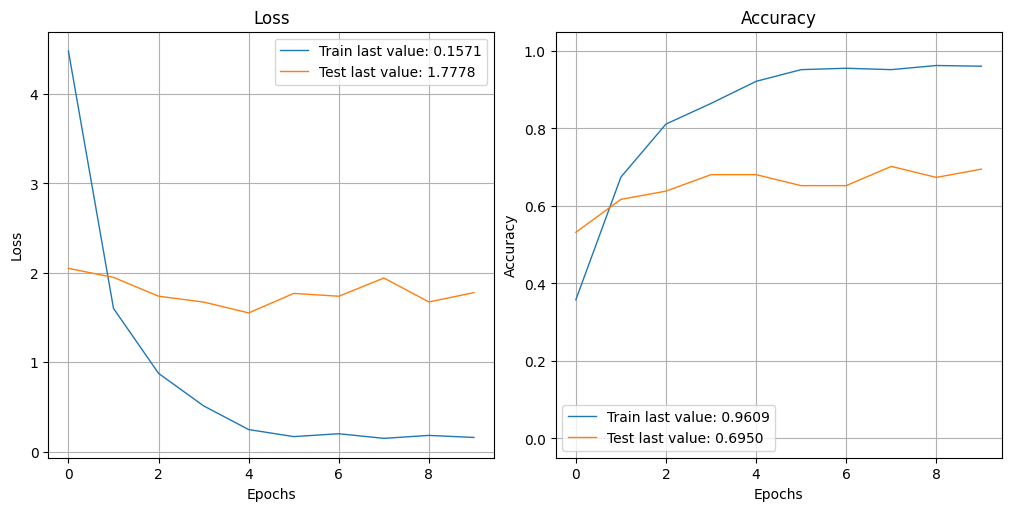

In [66]:
show_history(history)
#plot_history(history, path="standard.png")
plt.close()

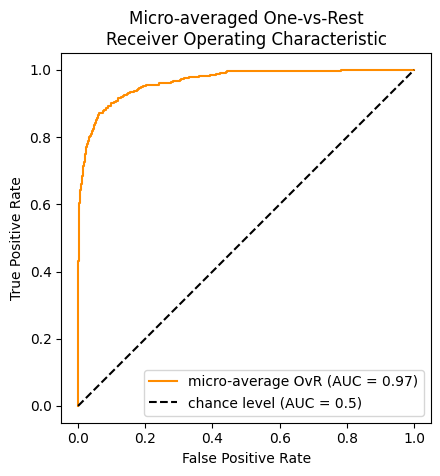

In [67]:
RocCurveDisplay.from_predictions(
    y_test.ravel(),
    pred_test.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [68]:
@interact
def show_ROC_mono(class_of_interest = labels_little):
    class_id = labels_little.index(class_of_interest)
    RocCurveDisplay.from_predictions(
        y_test[:, class_id],
        pred_test[:, class_id],
        name=f"{class_of_interest} vs the rest",
        color="darkorange",
    )

    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{class_of_interest} vs Rest ROC curves")
    plt.legend()
    return plt.show()

interactive(children=(Dropdown(description='class_of_interest', options=('Watches', 'Baby Care', 'Home Furnish…

# Data Augmentation

In [69]:
tmp = data_final['cat'].value_counts()

In [70]:
fig, ax = plt.subplots()
sns.histplot(tmp, shrink=.8, discrete=True, ax=ax)
ax.set_xlim(0,max(tmp)+1)
plt.show()

In [71]:
def show_from_cv2(img):
    plt.figure(figsize=(6, 6))
    
    plt.imshow(img)
    
    ax = plt.gca()
    plt.axis("off")
    return plt.show()

In [72]:
path = data_little['img'].iloc[0]

In [73]:
img = cv2.imread(path)
img = cv2.resize(img, dsize=(1000, 1000), interpolation=cv2.INTER_CUBIC)
show_from_cv2(img)

In [74]:
@interact
def change_hue(new=widgets.IntSlider(min=0, max=360, step=1, value=0)):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    hnew = np.mod(h + new, 180).astype(h.dtype)
    hsv_new = cv2.merge([hnew,s,v])
    img_new = cv2.cvtColor(hsv_new, cv2.COLOR_HSV2RGB)
    return show_from_cv2(img_new)

In [75]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis("off")
 
    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis("off")

In [76]:
flipped = tf.image.flip_left_right(img)
visualize(img, flipped)

In [77]:
saturated = tf.image.adjust_saturation(img, 256)
visualize(img, saturated)

In [78]:
tmp = tf.image.adjust_brightness(img, 0)
visualize(img, tmp)

In [79]:
tmp = tf.image.adjust_contrast(img, 1)
visualize(img, tmp)

In [80]:
tmp = tf.image.adjust_hue(img, -0.1)
visualize(img, tmp)

In [81]:
i = 1

In [82]:
bright = tf.image.stateless_random_hue(img, 0.1, (i, 0))
visualize(img, bright)
i += 1

In [83]:
bright = tf.image.stateless_random_contrast(img, 1, 1.1, (0, 2))
visualize(img, bright)

In [84]:
import albumentations as A

In [85]:
transform = A.Compose([
    #A.RandomCrop(width=256, height=256, p=1),
    #A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    #A.CLAHE(),
    #A.RandomRotate90(),
    #A.Transpose(),
    A.ShiftScaleRotate(
        shift_limit=0.02,
        scale_limit=[-0.2, 0.02],
        rotate_limit=0,
        interpolation=cv2.INTER_LANCZOS4,
        border_mode=cv2.BORDER_REFLECT_101,
        value=(255, 255, 255),
        p=0),
    A.Perspective(scale=(0.05, 0.1),
                keep_size=1,
                pad_mode=cv2.BORDER_REFLECT_101,
                pad_val=(255, 255, 255),
                fit_output=0,
                interpolation=cv2.INTER_LANCZOS4,
                p=0),
    A.SafeRotate(
        limit=10,
        interpolation=cv2.INTER_LANCZOS4,
        border_mode=cv2.BORDER_REFLECT_101,
        value=(255, 255, 255),
        p=0),
    #A.PiecewiseAffine(always_apply=False, p=1.0, scale=(0.03, 0.05), nb_rows=(4, 4), nb_cols=(4, 4), interpolation=4, mask_interpolation=0, cval=0, cval_mask=0, mode='wrap', absolute_scale=0, keypoints_threshold=0.01)
    #A.OpticalDistortion(),
    #A.RandomSnow(),
    #A.RandomShadow(),
    #A.RandomBrightnessContrast(p=.75),
    A.ColorJitter(
        brightness=0.1,
        contrast=0.2,
        saturation=0.2,
        hue=0.7,
        p=0.75),
    #A.Blur(blur_limit=1),
    A.GaussNoise(var_limit=(5.0, 50.0), p=0.5),
    A.Downscale(p=0.75, scale_min=0.5, scale_max=0.6, interpolation=cv2.INTER_AREA)
    #A.augmentations.geometric.resize.LongestMaxSize(max(input_shape[1:3])),
])

In [86]:
image = cv2.imread(data_little['img'].iloc[0])

In [87]:
fig, ax = plt.subplots(5, 3, figsize=(9, 15))
for i in range(15):
    image = load_img(data_little['img'].iloc[i], target_size=input_shape[1:3], interpolation='lanczos')
    image = np.array(image)
    transformed = transform(image=image)
    ax[i // 3, i % 3].imshow(transformed["image"])
plt.show()

In [88]:
def preprocess_image_augmented(path):
    image = load_img(path, target_size=input_shape[1:3], interpolation='lanczos')
    image = np.array(image)
    image = transform(image=image)['image']
    image = preprocess_input(image)
    return image

In [89]:
X_train_img, X_test_img, y_train_label, y_test_label = train_test_split(
    data_little['img'],
    data_little['label'],
    test_size=0.33,
    stratify=data_little['label'])

In [90]:
X_test = list(X_test_img.apply(preprocess_image))
X_test = np.asarray(X_test).astype(np.float32)

In [ ]:
y_test = to_categorical(y_test_label, num_classes=nb_cat_little)

In [ ]:
df = pd.DataFrame([X_train_img, y_train_label]).T

In [ ]:
df['label'].value_counts()

In [ ]:
X_augmented = []
y_augmented = []

but = int(np.quantile(df['label'].value_counts().to_list(), 0.8))
print("Nombre minimum d'images dans une classe :", but)
for i, n in df['label'].value_counts().items():
    if n >= but:
        but = n
    
    a_faire = but - n
    liste_images = df.loc[df['label']==i, 'img']
    for path in np.random.choice(liste_images, a_faire):
        img_tmp = preprocess_image_augmented(path)
        X_augmented.append(img_tmp)
        y_augmented.append(i)

X_augmented = np.asarray(X_augmented).astype(np.float32)

In [ ]:
if len(X_augmented) == 0:
    X_augmented = np.ndarray((0,) + input_shape[1:])

In [ ]:
for i in range(0):
    X_tmp = df["img"].apply(preprocess_image_augmented)
    X_tmp = np.asarray(list(X_tmp)).astype(np.float32)
    
    X_augmented = np.concatenate((X_augmented, X_tmp))
    
    y_tmp = df["label"].copy()
    
    y_augmented = np.concatenate((y_augmented, y_tmp))

In [ ]:
X_train = df["img"].apply(preprocess_image)

In [ ]:
X_train = np.asarray(list(X_train)).astype(np.float32)

In [ ]:
X_train.shape

In [ ]:
X_train = np.concatenate((X_train, X_augmented))

In [ ]:
X_train.shape

In [ ]:
len(df["label"])

In [ ]:
y_train = np.concatenate((df["label"], y_augmented))

In [ ]:
y_train.shape

In [ ]:
y_train = to_categorical(y_train, num_classes=nb_cat_little)

In [ ]:
y_train.shape

In [ ]:
base_model = VGG16(include_top=False, input_shape=input_shape[1:])
base_model.trainable = False

In [ ]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(nb_cat_little*10, activation='relu')
drop_out = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(nb_cat_little*4, activation='relu')
prediction_layer = layers.Dense(nb_cat_little, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    drop_out,
    dense_layer_2,
    prediction_layer
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy',  min_delta = 0.02, mode='max', patience=5, restore_best_weights=True)
es = EarlyStopping(monitor='val_loss', min_delta = 0.02, mode='min', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, validation_split=0.4, batch_size=16, callbacks=[es])

In [ ]:
pred_train = model.predict(X_train)

In [ ]:
balanced_accuracy_score([cat_to_label(e) for e in pred_train], [cat_to_label(e) for e in y_train])

In [ ]:
labels_little = data_little.sort_values('label')['cat'].drop_duplicates().to_list()

In [ ]:
print(classification_report(
    [cat_to_label(e) for e in y_train],
    [cat_to_label(e) for e in pred_train],
    target_names=labels_little,
    zero_division=0))

In [ ]:
pred_test = model.predict(X_test)

In [ ]:
y_test_label = [cat_to_label(e) for e in y_test]

In [ ]:
accuracy_score(y_test_label, [cat_to_label(e) for e in pred_test])

In [ ]:
cohen_kappa_score(y_test_label, [cat_to_label(e) for e in pred_test])

In [ ]:
matthews_corrcoef(y_test_label, [cat_to_label(e) for e in pred_test])

In [ ]:
top_k_accuracy_score(y_test_label, pred_test, k=2)

In [ ]:
print(classification_report(
    [cat_to_label(e) for e in y_test],
    [cat_to_label(e) for e in pred_test],
    target_names=labels_little,
    zero_division=0))

In [ ]:
show_history(history)
#plot_history(history, path="standard.png")
plt.close()

In [ ]:
RocCurveDisplay.from_predictions(
    y_test.ravel(),
    pred_test.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [ ]:
def get_max_coord(data):
    max_value = data.values.max()
    return list(zip(*np.where(data.values == max_value)))[0]

In [ ]:
def compare_clustering(original, predict, return_cat=False):
    data_show = pd.DataFrame(original, columns=['cat'])
    data_show['pred'] = predict
    data_show = pd.get_dummies(data_show, columns=['pred'])
    data_show = data_show.groupby('cat').sum(numeric_only=True)

    cat_restante = list(data_show.index)
    col_restante = list(data_show.columns)
    cat_final = []
    col_final = []
    for i in range(len(data_show)):
        i_cat, i_col = get_max_coord(data_show.loc[cat_restante, col_restante])
        n_col, n_cat = col_restante[i_col], cat_restante[i_cat]

        col_final.append(n_col)
        col_restante.remove(n_col)
        cat_final.append(n_cat)
        cat_restante.remove(n_cat)
    
    if return_cat:
        return cat_final, col_final

    print('ARI : ', adjusted_rand_score(original, predict))
    
    return data_show.loc[cat_final, col_final].style.background_gradient(cmap="YlGnBu", axis=0)

In [ ]:
labels_little = data_little.sort_values('label')['cat'].drop_duplicates().to_list()

In [ ]:
y_final_test = [cat_to_label(e) for e in y_test]
y_final_pred_test = [cat_to_label(e) for e in pred_test]

In [ ]:
compare_clustering([labels_little[i] for i in y_final_test], y_final_pred_test)

In [ ]:
list_cat, list_col = compare_clustering([labels_little[i] for i in y_final_test], y_final_pred_test, True)

In [ ]:
tmp = pd.DataFrame()

In [ ]:
tmp['label'] = [labels_little[i] for i in y_final_test]
tmp['pred'] = [labels_little[i] for i in y_final_pred_test]

In [ ]:
@interact
def show_img(reel=list_cat, predit=list_cat, index=range(0, 10)):
    
    l = list(tmp.loc[(tmp['label']==reel) & (tmp['pred']==predit)].index)
    
    print("Nombre de lignes : ", len(l))
    if index >= len(l):
        return None

    print("Index de cette image dans tmp : ", l[index])
    
    img = cv2.imread(X_test_img.iloc[l[index]])
    h, w = img.shape[:2]
    aspect = h/w
    img = cv2.resize(img, dsize=(400, int(400*aspect)), interpolation=cv2.INTER_CUBIC)
    return show_from_cv2(img)